# Mini-projet Groupe 1 : Charge d'une flotte de véhicules électriques

## 1. Modélisation

### Question 1 :

On suppose que les batteries des voitures sont identiques. Notons le taux de charge relative $\tau\,=\,\frac{q}{q_{max}}$ où $q$ est la charge absolue de la batterie, $q_{max}$ la charge absolue maximale et $P$ la puissance fournie à la batterie. 

On suppose qu'il y a toujours assez de bornes de recharge pour les voitures qui souhaitent être rechargées. On note $n$ le nombre de voitures et pour chaque voiture $j$ le temps $t^0_j$ d'arrivée et $t^f_j$ le temps de départ ainsi que $\tau^0_j$ et $\tau^f_j$ les taux de charge relatifs à l'arrivée et au départ.

Notons $f$ la fonction objectif du problème qui est le coût de recharge lié à la consommation électrique qui dépend de l'intensité $I_j$ qui parcourt chaque borne de recharge $j$ à tout instant.
    
$f(I)\,=\,\int^{t_f}_{t_0}\sum_{j=1}^nI_j(t)\,Up(t)dt$ où $t_0 = \displaystyle \max_{j}(t^0_j)$, $t_f = \displaystyle \max_{j}(t^f_j)$, $U$ la tension du réseau (que l'on suppose fixe égale à $230 V$) et $p(t)$ est le prix de l'électricité en euros/$kWh$.

### Question 2 :

On a : $\frac{dq}{dt}(t) = \alpha\,I(t) = \alpha\,\frac{P(t)}{U}$ d'où : $\frac{d\tau}{dt}(t) =\alpha\, \frac{P(t)}{U*q_{max}} = \alpha\, \frac{I(t)}{q_{max}}$ où $\alpha$ est un facteur lié aux pertes diverses de charge (effet Joule, cablage...) à déterminer expérimentalement. 

### Question 3 :

On va ici traiter de l'évaluation expérimentale de notre modèle, i.e. le calcul par la régression (linéaire dans notre cas, puisque la relation $\frac{dq}{dt}(I)$ est linéaire). On trace d'après les données fournies $\frac{dq}{dt}(t)$ en fonction de $I(t)$.

Etant donné que du bruit a été ajouté aux données et qu'on a accès à $q(t)$ et non $\frac{dq}{dt}(t)$, on va tenter deux méthodes de régression : 
* La première consiste à extrapoler $\frac{dq}{dt}(t)$ d'après les données et tracer cette approximation en fonction de $I(t)$ donné
* La seconde consiste à intégrer $I(t)$ par méthode numérique et tracer $q$ en fonction de  $\int I$.

Dans les deux cas, on aura un coefficient de régression qui vaudra (si tant est que le modèle linéaire est juste) $\frac{\alpha}{q_{max}}$.

In [1]:
#traitement des données, mise en forme sous un panda
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

table = pd.read_table('donnees-projet-gr1.txt', names=['temps', 'intensité', 'charge_relative'])
table.head()

,temps,intensité,charge_relative
0,0.000000,0.005755,0.626524
1,1.005016,0.018529,0.631323
2,2.008215,-0.022398,0.629266
3,3.018137,0.008812,0.631987
4,4.023168,0.003566,0.632518


##### Par le calcul de la dérivée

In [2]:
### On calcule la dérivée de la charge
table_der = table.copy(deep = True)
table_der['derivee_charge'] = 0
for i in table_der.index :
    if i == 0:
        table_der.iloc[i, 3] = 0
    else :
        table_der.iloc[i, 3] = (table_der.iloc[i-1, 2] - table_der.iloc[i, 2])/(table_der.iloc[i-1, 0] - table_der.iloc[i, 0])
table_der.drop([0], inplace = True) ### On supprime la première ligne car on a pas la dérivée de la charge pour cette ligne.
table_der.head()

,temps,intensité,charge_relative,derivee_charge
1,1.005016,0.018529,0.631323,0.004775
2,2.008215,-0.022398,0.629266,-0.002050
3,3.018137,0.008812,0.631987,0.002694
4,4.023168,0.003566,0.632518,0.000529
5,5.027335,-0.012886,0.632880,0.000360


In [3]:
### On crée notre fonction objectif
def f(a):
    s = 0
    for i in table_der.index :
        s += (table_der.loc[i, 'derivee_charge'] - a*table_der.loc[i, 'intensité'] )**2
    return s

In [4]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(f)
res

     fun: 0.002029256395442698
    nfev: 27
     nit: 23
 success: True
       x: 0.0019426071168044741

On trouve donc que $\frac{d\tau}{dt} = 0.00194 \times I$ avec une erreur de 0.00203.

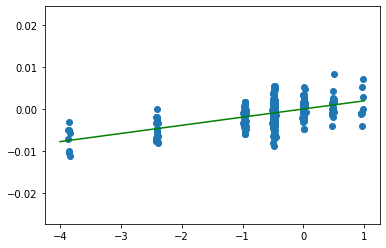

In [5]:
plt.scatter(table_der['intensité'], table_der['derivee_charge'])
x = np.linspace(-4, 1)
plt.plot(x, 0.0019426071168044741*x, 'g')

Remarquons d'abord que cette régression ne semble pas très précise: la méthode des moindres carrés fait passer la droite par la moyenne quadratique des bruits. Etant donné que le bruit a été rajouté artificiellement, on peut se douter que la moyenne quadratique donne une bonne indication de la valeur réelle. Cependant, si l'on avait un bruit pondéré (par exemple avec beaucoup de marge vers le bas) ou borné, la valeur du coefficient de régression inspirerait peut de confiance.

Pour valider ce résultat (ou l'infirmer), on va passer par une méthode d'intrégration.

##### Par intégration

In [6]:
### On intègre I par la méthode des trapèzes
table_int = table.copy(deep = True)
table_int['int_I'] = 0
for i in table_int.index :
    if i == 0 : ### Calcul de l'intégrale entre t0 et t1
        table_int.iloc[i, 3] = (table_int.iloc[i+1, 0] - table_int.iloc[i, 0])*(table_int.iloc[i, 1] + table_int.iloc[i, 1])/2
    elif i!=298 : ### On calcule l'intégrale de I entre ti et t(i+1) et on ajoute la valeur de l'intégrale entre t0 et ti
        table_int.iloc[i, 3] = table_int.iloc[i-1,3]+(table_int.iloc[i+1, 0] - table_int.iloc[i, 0])*(table_int.iloc[i, 1] + table_int.iloc[i, 1])/2
    else : ### On ne peut pas caluler la dernière intégrale
        table_int.iloc[i, 3] = 0
table_int.drop([298], inplace = True) ###La dernière valeur n'a pas de sens.
table_int.head()

,temps,intensité,charge_relative,int_I
0,0.000000,0.005755,0.626524,0.005784
1,1.005016,0.018529,0.631323,0.024373
2,2.008215,-0.022398,0.629266,0.001753
3,3.018137,0.008812,0.631987,0.010609
4,4.023168,0.003566,0.632518,0.014190


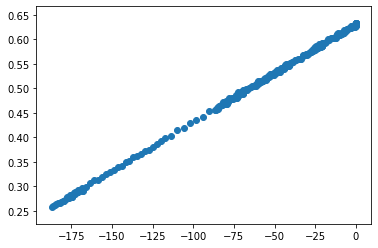

In [7]:
plt.scatter(table_int['int_I'], table_int['charge_relative'])

In [8]:
### On crée notre nouvelle fonction objectif
def g(a):
    s = 0
    for i in  table_int.index :
        s += (table_int.loc[i, 'charge_relative'] - a*table_int.loc[i, 'int_I'] - table_int.loc[0, 'charge_relative'])**2
    return s

In [9]:
from scipy.optimize import minimize_scalar
res = minimize_scalar(g)
res

     fun: 0.00315681526792678
    nfev: 9
     nit: 5
 success: True
       x: 0.0019568267225706162

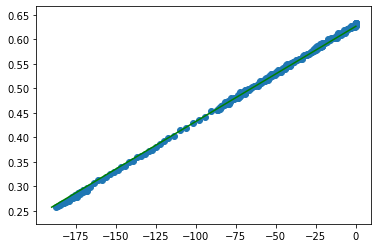

In [10]:
plt.scatter(table_int['int_I'], table_int['charge_relative'])
x = np.linspace(-190, 0)
plt.plot(x, 0.0019426071168044741*x + table_int.loc[0, 'charge_relative'], 'g')

Ce graphe est nettement plus satisfaisant: on retrouve bien une relation affine de la forme $ q = a \int I+q_0$.
On retrouve le même coefficient directeur, qui vaut environ 0.0020. 

On valide donc le modèle proposé, soit $\frac{d\tau}{dt}\,=\,\frac{\alpha}{q_{max}}\times I$ avec $\frac{\alpha}{q_{max}}=0,002$

### Question 4 :

#### Contraintes du problème

Nous avons donc la fonction objectif du problème $f$ qu'il faut minimiser en fonction du vecteur $I$ des instensités. Ecrivons à présent les contraintes du porblème. 

- $I_j(t) = 0$ pour $t \notin [t_j^0, t_j^f]$ pour tout $j$ : la voiture ne peut pas charger si elle n'est pas là.
- $\tau_j(t) \in [0, 1]$ pour tout $t$ et tout $j$ : le taux de charge relatif est compris entre 0 et 1. (deux conditions en une)
- $\tau_j(t_j^0) = \tau^0_j$ pour tout $j$ : le taux de charge de la voiture $j$ lorsque la voiture arrive est égal à la charge initial.
- $\tau_j(t_j^f) \geq \tau^f_j$ pour tout $j$ : le taux de charge de la voiture $j$ lorsque la voiture part est supérieur ou égal au taux de charge final voulu.
- $\sum_{j=1}^n I_j(t)U \leq P_{max}$ pout tout $t$ : la puissance fournie à tout instant $t$ aux voitures ne dépasse pas la puissance maximale $P_{max}$ du réseau. 
- $\frac{d\tau_j(t)}{dt}\,=\,\frac{\alpha}{q_{max}}\times I_j(t)$ avec $\frac{\alpha}{q_{max}}=0,002$ pour tout $t$ et tout $j$.

#### Version discrète du problème

On peut ensuite passer à une version discrétisée du problème pour avoir un problème d'optimisation sous contraintes en dimension finie : 

On commence par discrétiser le temps en $N$ pas. On pose $T_0 = t_0$ et $T_k = T_0 + k\times \Delta T$ où $\Delta T = \frac{t_f - t_0}{N}$ de sorte que $T_N = t_f$. On choisit de réécrire les temps d'arrivée et de départ d'une voiture $j$, $t_j^0 = T_{k_j^0}$ et $t_j^f = T_{k_j^f}$.

Ensuite, on reécrit notre fonction objectif : $f(I) = \sum_{k=0}^{N-1} \sum_{j=1}^n I_j(T_k)\times U \times p(T_k)\Delta T$ (on a intégré selon la méthodes des rectangles à gauche).

Et enfin, nos contraintes :
- $I_j(T_k) = 0$ pour $T_k \notin [T_{k_j^0},T_{k_j^f}]$ ou encore pour tout $k \notin [\![k_j^0, k_j^f ]\!]$ et pour tout $j$: la voiture ne peut pas charger si elle n'est pas là.
- $\tau_j(T_k) \in [0, 1]$ pour tout $k$ et tout $j$ : le taux de charge relatif est compris entre 0 et 1. (deux conditions en une)
- $\tau_j(T_{k_j^0}) = \tau^0_j$ pour tout $j$ : le taux de charge de la voiture $j$ lorsque la voiture arrive est égal à la charge initial.
- $\tau_j(T_{k_j^f}) \geq \tau^f_j$ pour tout $j$: le taux de charge de la voiture $j$ lorsque la voiture part est supérieur ou égal au taux de charge final voulu.
- $\sum_{j=1}^n I_j(T_k)U \leq P_{max}$ pout tout $k$ : la puissance fournie à tout instant aux voitures ne dépasse pas la puissance maximale $P_{max}$ du réseau. 
- $\tau_j(T_{k+1})\,=\,\tau_j(T_{k}) + \frac{\alpha}{q_{max}}\times I_j(T_k)$ avec $\frac{\alpha}{q_{max}}=0,002$ pour tout $k$ et tout $j$.

##### Version avec des matrices

On peut aussi réécrire ce problème en utilisant trois matrices et la norme 1 sur $R^n$. 

On utilise la matrice I des intensités telle que $I_{j,k} = I_j(T_k)$, la matrice colonne P des prix telle $P_k = p(T_k)$ et la matrice $\tau$ des charges relatives telle que $\tau_{j,k} = \tau_j(T_k)$.

La fonction objectif est alors : $f(I) = U\times \Delta T \times||I\times P||_1$ (cette relation n'est valable que lorsque tous les coefficients de $I$ sont positifs).

Et les contraintes s'écrivent :
- $I_{j,k} = 0$ pour tout $j$ et pour tout $k \notin [\![k_j^0, k_j^f ]\!]$ 
- $\tau_{j,k} \in [0, 1]$ pour tout $k$ et tout $j$ 
- $\tau_{j,k_j^0} = \tau^0_j$ pour tout $j$ 
- $\tau_{j,k_j^f} \geq \tau^f_j$ pout tout $j$
- $||U\times I_k||_1\leq P_{max}$ pout tout $k$ où $I_k$ est la $k^{ème}$ colonne de $I$.
- $\tau_{j,k+1}\,=\,\tau_{j,k} + \frac{\alpha}{q_{max}}\times I_{j,k}$ avec $\frac{\alpha}{q_{max}}=0,002$ pour tout $k$ et tout $j$.